---
title: Place New Strains in Spectral Tree
author: Benjamin Doran
date: Dec 2023
---

In [313]:
#| code-fold: true
#| code-summary: julia-setup
using DrWatson
@quickactivate projectdir()

using HypothesisTests
using MultipleTesting: adjust, BenjaminiHochberg, Bonferroni
using SpectralInference
using NeighborJoining
using NewickTree
using StatsBase
using CSV, DataFrames, Muon
include(srcdir("helpers.jl"))

bbtreedir = datadir("exp_pro", "BB669") |> mkpath
pdir_csbtree = plotsdir("CSB669_trees") |> mkpath
pdir_csb_micurve = plotsdir("CSB669_micurve") |> mkpath


using StatsPlots
theme(:default, grid=false, label=false, tickdir=:out)

using RCall
R"""
library(ape)
library(treeio)
library(ggtree)
library(ggplot2)
library(tidyverse)

setwd($(projectdir()))
""";


## Projecting in strains from the commensal strain bank

In [2]:
uniprot = readh5ad(datadir("exp_raw", "UP7047", "2020_02_UP7047.h5ad"))
biobank = readh5mu(datadir("exp_raw", "BB669", "BB669.h5mu"))

┌ Warning: Cannot join columns with the same name because var_names are intersecting.
└ @ Muon /Users/bend/.julia/packages/Muon/eLqpV/src/mudata.jl:351


MuData object 669 ✕ 21475
└ metabolites_foldchange
  AnnData object 669 ✕ 50
└ UPorder_oggs
  AnnData object 669 ✕ 10177
└ oggs
  AnnData object 669 ✕ 11248

In [3]:
upmtx = uniprot.X[:, :]
upusv = svd(upmtx)
bbmtx = biobank["UPorder_oggs"].X[:,:]
size(bbmtx)

(669, 10177)

In [4]:
# project into uniprot spectral latent space
# uses ̂u = newdata * V * S_inverse
bbuhat = projectinLSV(bbmtx, upusv)

669×7047 Matrix{Float64}:
 -0.00710957  -0.016346   0.0109378   …   0.0620108   -0.195298
 -0.0101422   -0.0235557  0.0183793       0.290321    -0.216655
 -0.00988477  -0.0228117  0.0172847       0.197863    -0.268172
 -0.00911707  -0.0213556  0.0163378      -0.201534    -0.00658134
 -0.0100938   -0.0234382  0.0181515      -0.245223    -0.123784
 -0.0100751   -0.0234404  0.018099    …  -0.247896    -0.121264
 -0.0126152   -0.0291861  0.0252202      -0.204816    -0.265976
 -0.00982738  -0.0232259  0.0177415      -0.25874     -0.253145
 -0.0130485   -0.0308516  0.0269812      -0.270194     0.0506157
 -0.00927287  -0.0215109  0.0162395      -0.171792    -0.0400535
  ⋮                                   ⋱   ⋮           
 -0.00895884  -0.0207339  0.0178657   …   0.106219    -0.317428
 -0.00903688  -0.0208161  0.0180687       0.118437    -0.345223
 -0.0129656   -0.0307315  0.027649       -0.133769    -0.110028
 -0.00931925  -0.0204614  0.0181975      -0.00752627  -0.526419
 -0.00569943  -0.01

In [53]:
dij = spectraldistances(bbuhat, upusv.S; alpha=1.5, q=.75);
treestr = NeighborJoining.newickstring(regNJ(dij), biobank.obs_names)
bbtree = readnw(treestr)
ladderize!(bbtree)

669

In [15]:
# write out CSB biobank tree
open(joinpath(bbtreedir, "BB669-tree.nw"), "w") do io
    writenw(io, bbtree)
end

18586

In [47]:
R"""
bb669obs = read.table($(datadir("exp_raw", "BB669", "BB669_rowmeta.tsv")), sep="\t", header=1)
bb669obs$NCBI.Family[bb669obs$NCBI.Family == "<unclassified>"] = "<unknown family>"
bb669obs$ID = bb669obs$Strain.ID
bb669tree = read.newick($(joinpath(bbtreedir, "BB669-tree.nw")))
bb669tree = as.treedata(left_join(as_tibble(bb669tree), bb669obs, by = c("label" = "Strain.ID")))
bb669tree_tbl = as_tibble(bb669tree)

mode_family = offspring(bb669tree_tbl, bb669tree_tbl$node, tiponly = FALSE, self_include = TRUE)
mode_family = unlist(lapply(mode_family, function(x) modeest::mfv1(x$NCBI.Family, na_rm=TRUE)))

bb669tree_tbl$mode_family = mode_family
bb669tree_tbl$label = paste(str_pad(bb669tree_tbl$ID, 10, side="right"), bb669tree_tbl$NCBI.Species, sep=" ")
bb669tree = as.treedata(bb669tree_tbl)
familynames = names(sort(table(bb669obs$NCBI.Family), decreasing = TRUE))

colorvalues = RColorBrewer::brewer.pal(12, name="Set3")
p = ggtree(bb669tree, 
    aes(color=mode_family), 
    size=.5,
    layout="fan", open.angle=10,
    branch.length="none",
    )  %>% rotate_tree(-90) +
    ggtitle("CSB Spectral Tree (N=669, UP context)") + 
    scale_color_manual(values=colorvalues, breaks=familynames)
ggsave(file.path($pdir_csbtree, "CSB669_SPItree.svg"), 
    p,
    height=10,
    width=10,
)
"""
show_svg(joinpath(pdir_csbtree, "CSB669_SPItree.svg"))

┌ Warning: RCall.jl: Scale for y is already present.
│ Adding another scale for y, which will replace the existing scale.
│ Coordinate system already present. Adding new coordinate system, which will
│ replace the existing one.
└ @ RCall /Users/bend/.julia/packages/RCall/YrsKg/src/io.jl:172


Add labels to the tips

In [49]:
R"""
p = ggtree(bb669tree, 
    aes(color=mode_family), 
    size=.5,
    layout="fan", open.angle=10,
    branch.length="none",
    )  %>% rotate_tree(-90) +
    geom_tiplab2(aes(text=label), size=1, family="mono") +
    ggtitle("CSB Spectral Tree (N=669, UP context)") +
    scale_color_manual(values=colorvalues, breaks=familynames)
ggsave(file.path($pdir_csbtree, "CSB669_SPItree_withtiplabels.svg"), 
    p,
    height=10,
    width=10,
)
"""
show_svg(joinpath(pdir_csbtree, "CSB669_SPItree_withtiplabels.svg"))

┌ Warning: RCall.jl: Scale for y is already present.
│ Adding another scale for y, which will replace the existing scale.
│ Coordinate system already present. Adding new coordinate system, which will
│ replace the existing one.
└ @ RCall /Users/bend/.julia/packages/RCall/YrsKg/src/io.jl:172


## Sub-trees

In [50]:
nthparent(n, i) = i < 1 ? n : nthparent(parent(n), i-1)
rename_treeleaves!(tree, idmapping) = begin
    for node in getleaves(tree)
        NewickTree.setname!(node, idmapping[name(node)])
    end
    tree
end

rename_treeleaves! (generic function with 1 method)

In [58]:
bbtree_leaves = getleaves(bbtree);

In [71]:
targetid = "DFI.1.13"
basenode = bbtree_leaves[findfirst(n->name(n) == targetid, bbtree_leaves)]
subtree = readnw(nwstr(nthparent(basenode, 3)))
tiplabels = join.(eachrow(biobank.obs[indexin(getleafnames(subtree), biobank.obs.Strain_ID), [:Strain_ID, :NCBI_Species]]), " ")
idmapping = Dict(k=>v for (k,v) in zip(getleafnames(subtree), tiplabels))
rename_treeleaves!(subtree, idmapping)
plot(subtree,
    c=:turquoise3, alpha=.5,
    lw=2, fs=7,
    size=(600,600),
    rightmargin=5Plots.cm,
    yflip=true
)

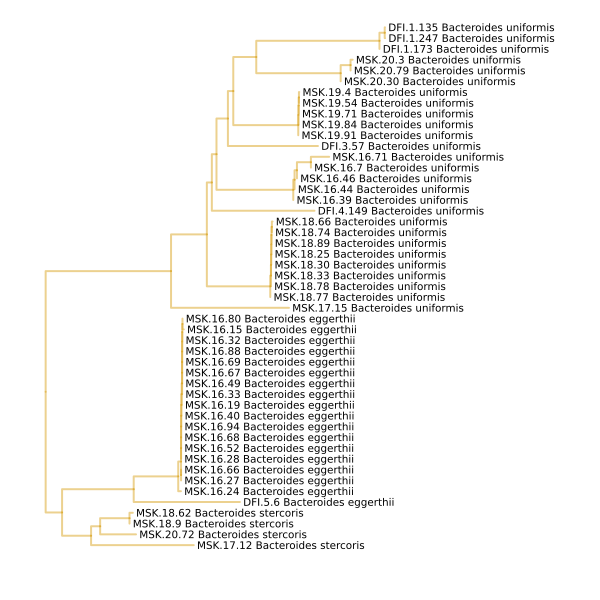

In [74]:
targetid = "MSK.17.12"
basenode = bbtree_leaves[findfirst(n->name(n) == targetid, bbtree_leaves)]
subtree = readnw(nwstr(nthparent(basenode, 3)))
tiplabels = join.(eachrow(biobank.obs[indexin(getleafnames(subtree), biobank.obs.Strain_ID), [:Strain_ID, :NCBI_Species]]), " ")
idmapping = Dict(k=>v for (k,v) in zip(getleafnames(subtree), tiplabels))
rename_treeleaves!(subtree, idmapping)
plot(subtree,
    c=:goldenrod, alpha=.5,
    lw=2, fs=7,
    size=(600,600),
    rightmargin=5Plots.cm,
)

One thing to notice as we view these sub trees is that they are grouping by NCBI species, but there are further sub-groupings within each species. The ID convention for our strains is "<sampling hospital>.<donor>.<strain>". Knowing this naming convention we realized that the sub-groups were corresponding to the donor these strains were sampled from

This becomes more obvious as we color by donor id

In [83]:
donorcolormap = Dict(k=>v for (k,v) in zip(unique(biobank.obs.Donor), palette(:glasbey_bw_n256, length(unique(biobank.obs.Donor)))));

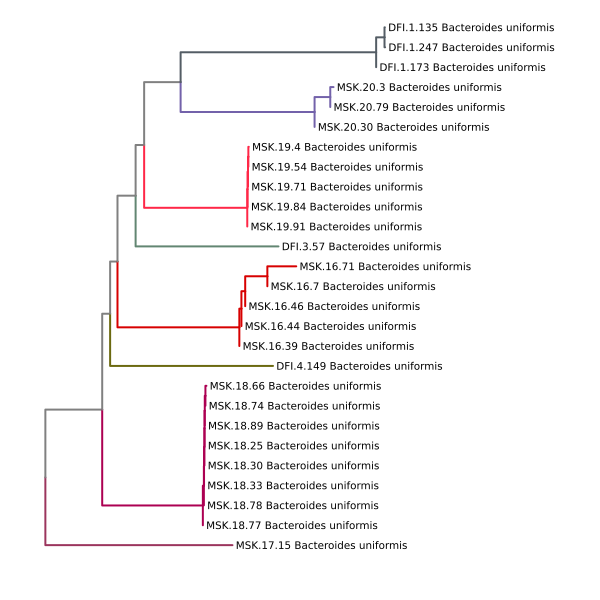

In [87]:
# sub-setting to B. uniformis strains
targetid = "MSK.17.15"
basenode = bbtree_leaves[findfirst(n->name(n) == targetid, bbtree_leaves)]
subtree = readnw(nwstr(nthparent(basenode, 1)))

linecolors = map(prewalk(subtree)) do node
    leafids = getleafnames(node)
    donorids = biobank.obs.Donor[indexin(leafids, biobank.obs.Strain_ID)]
    length(unique(donorids)) == 1 ? donorcolormap[mode(donorids)] : :grey
end |> x->x[2:end] |> permutedims

tiplabels = join.(eachrow(biobank.obs[indexin(getleafnames(subtree), biobank.obs.Strain_ID), [:Strain_ID, :NCBI_Species]]), " ")
idmapping = Dict(k=>v for (k,v) in zip(getleafnames(subtree), tiplabels))
rename_treeleaves!(subtree, idmapping)
plot(subtree,
    c=linecolors,
    lw=2, fs=7,
    size=(600,600),
    rightmargin=5Plots.cm,
)

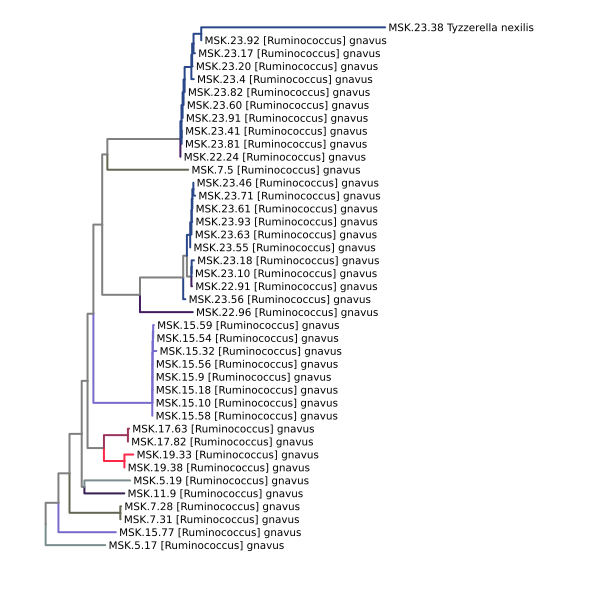

In [101]:
# sub-setting to M. gnavus strains
targetid = "MSK.22.24"
basenode = bbtree_leaves[findfirst(n->name(n) == targetid, bbtree_leaves)]
subtree = readnw(nwstr(nthparent(basenode, 9)))

linecolors = map(prewalk(subtree)) do node
    leafids = getleafnames(node)
    donorids = biobank.obs.Donor[indexin(leafids, biobank.obs.Strain_ID)]
    length(unique(donorids)) == 1 ? donorcolormap[mode(donorids)] : :grey
end |> x->x[2:end] |> permutedims

tiplabels = join.(eachrow(biobank.obs[indexin(getleafnames(subtree), biobank.obs.Strain_ID), [:Strain_ID, :NCBI_Species]]), " ")
idmapping = Dict(k=>v for (k,v) in zip(getleafnames(subtree), tiplabels))
rename_treeleaves!(subtree, idmapping)
plot(subtree,
    c=linecolors,
    lw=2, fs=7,
    size=(600,600),
    rightmargin=5Plots.cm,
)

## Mutual information across tree

### NCBI taxonomy

In [282]:
NBOOTS = 50;
colnames = [:NCBI_Phylum, :NCBI_Class, :NCBI_Order, :NCBI_Family, :NCBI_Genus, :NCBI_Species, :Donor];

In [283]:
BB_NCBI_taxonomy = biobank.obs[:, colnames]
obs_names = biobank.obs_names.vals;
rowmask = map(eachrow(BB_NCBI_taxonomy)) do row
    !any(==("<unclassified>"), row)
end;
mi_results = map(1:NBOOTS) do i
	pairedMI_across_treedepth(eachcol(BB_NCBI_taxonomy), obs_names, bbtree; mask=rowmask, bootstrap=true, ncuts=100, treecut_distancefun=network_distance)
end;

In [284]:
mi_results_df = DataFrame()
for (i, res) in enumerate(mi_results)
    mi_results_df = vcat(
        mi_results_df, 
        hcat(
            DataFrame(bootstrap=i, treedepth=last(res)),
            DataFrame(first(res), colnames),
            DataFrame(scaledcumsum.(first(res)), string.(colnames) .* "_scaledcumsum"),
        )
    )
end

CSV.write(joinpath(bbtreedir, "NCBI_raw_MI_values.csv"), mi_results_df)
first(mi_results_df, 5)

5×16 DataFrame
 Row │ bootstrap  treedepth  NCBI_Phylum  NCBI_Class  NCBI_Order  NCBI_Family  ⋯
     │ Int64      Float64    Float64      Float64     Float64     Float64      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │         1   0.0        0.0         0.0         0.0          0.0         ⋯
   2 │         1   0.414141   0.00882844  0.00833942  0.00821489   0.0064997
   3 │         1   0.828283   0.00889856  0.00864961  0.00814509   0.0064801
   4 │         1   1.24242    0.0102742   0.0100259   0.00949992   0.00760295
   5 │         1   1.65657    0.0104848   0.0101054   0.0100504    0.00739362  ⋯
                                                              10 columns omitted

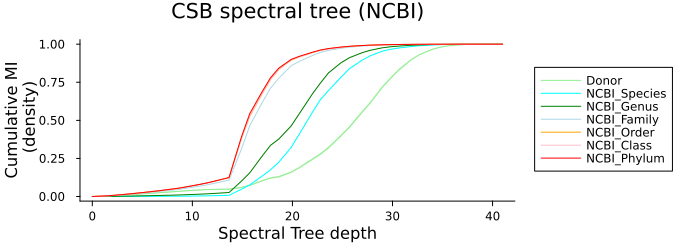

In [285]:
pltdf = mi_results_df |>
    df -> stack(df, 10:16, [:bootstrap, :treedepth]) |> 
    df -> transform(df, :variable => ByRow(x->replace(x, "_scaledcumsum"=>"")) => identity) |>
    df -> groupby(df, [:variable, :treedepth]) |>
    df -> combine(df,
        :value => mean => :MI_mean,
        :value => std => :MI_std,
    ) |> 
    df -> sort(df, [])

taxonomylevels = permutedims(string.(colnames))
taxarankcolors = [:red :pink :orange :lightblue :green :aqua :lightgreen];

plot(title="CSB spectral tree (NCBI)", ylabel="Cumulative MI\n (density)", xlabel="Spectral Tree depth",
    legend=:outerright,
    size=(700,250),
    margin=5Plots.mm,  
)
for (tlab, tcol) in reverse(collect(zip(taxonomylevels, taxarankcolors)))
    df = filter(:variable => ==(tlab), pltdf)
    @df df plot!(:treedepth, :MI_mean, ribbon=2 .* :MI_std, label=tlab, c=tcol, lw=1)
end
plot!()

### GTDB Taxonomy

In [286]:
NBOOTS = 50;
colnames = [:GTDB_Phylum, :GTDB_Class, :GTDB_Order, :GTDB_Family, :GTDB_Genus, :GTDB_Species, :Donor];

In [287]:
BB_NCBI_taxonomy = biobank.obs[:, colnames]
obs_names = biobank.obs_names.vals;
rowmask = map(eachrow(BB_NCBI_taxonomy)) do row
    !any(==("<unclassified>"), row)
end;
mi_results = map(1:NBOOTS) do i
	pairedMI_across_treedepth(eachcol(BB_NCBI_taxonomy), obs_names, bbtree; mask=rowmask, bootstrap=true, ncuts=100, treecut_distancefun=network_distance)
end;

In [288]:
mi_results_df = DataFrame()
for (i, res) in enumerate(mi_results)
    mi_results_df = vcat(
        mi_results_df, 
        hcat(
            DataFrame(bootstrap=i, treedepth=last(res)),
            DataFrame(first(res), colnames),
            DataFrame(scaledcumsum.(first(res)), string.(colnames) .* "_scaledcumsum"),
        )
    )
end

CSV.write(joinpath(bbtreedir, "GTDB_raw_MI_values.csv"), mi_results_df)
first(mi_results_df, 5)

5×16 DataFrame
 Row │ bootstrap  treedepth  GTDB_Phylum  GTDB_Class  GTDB_Order  GTDB_Family  ⋯
     │ Int64      Float64    Float64      Float64     Float64     Float64      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │         1   0.0        0.0         0.0         0.0          0.0         ⋯
   2 │         1   0.414141   0.00806298  0.0080814   0.00806191   0.00706748
   3 │         1   0.828283   0.00843922  0.00836679  0.00845619   0.00706503
   4 │         1   1.24242    0.00986423  0.00980809  0.00969203   0.00765562
   5 │         1   1.65657    0.0102265   0.00953659  0.00919257   0.0084261   ⋯
                                                              10 columns omitted

In [289]:
pltdf = mi_results_df |>
    df -> stack(df, 10:16, [:bootstrap, :treedepth]) |> 
    df -> transform(df, :variable => ByRow(x->replace(x, "_scaledcumsum"=>"")) => identity) |>
    df -> groupby(df, [:variable, :treedepth]) |>
    df -> combine(df,
        :value => mean => :MI_mean,
        :value => std => :MI_std,
    ) |> 
    df -> sort(df, [])

taxonomylevels = permutedims(string.(colnames))
taxarankcolors = [:red :pink :orange :lightblue :green :aqua :lightgreen];

plot(title="CSB spectral tree (GTDB)",  ylabel="Cumulative MI\n (density)", xlabel="Spectral Tree depth",
    legend=:outerright,
    size=(700,250),
    margin=5Plots.mm,  
)
for (tlab, tcol) in reverse(collect(zip(taxonomylevels, taxarankcolors)))
    df = filter(:variable => ==(tlab), pltdf)
    @df df plot!(:treedepth, :MI_mean, ribbon=2 .* :MI_std, label=tlab, c=tcol, lw=1)
end
plot!()

## Relative Distances

Comparing the Spectral tree to the 16S or bac120 trees
tree

In [308]:
# strain ids for 669 samples in CSB
obs_names = biobank.obs.Strain_ID;

# re-read in biobank tree (same as what is plotted above)
bbtree = readnw(readline(joinpath(bbtreedir, "BB669-tree.nw")))
as_polytomy!(n->NewickTree.support(n)<0.5, bbtree)
ladderize!(bbtree)
leafnames_spitree = getleafnames(bbtree); # same order as returned by patristic_distances
order_treespitree = indexin(leafnames_spitree, obs_names);

# read in tree built from bac120 annotations
treebac120 = readnw(readline(projectdir("_research","BB669_bac120_phyml","BB669_bac120.phy-supporttree.txt")))
as_polytomy!(n->NewickTree.support(n)<0.5, treebac120)
ladderize!(treebac120)
leafnames_bac120 = getleafnames(treebac120); # same order as returned by patristic_distances
order_treebac120 = indexin(leafnames_bac120, obs_names);

# read in tree built from 16S sequence
tree16s = readnw(readline(projectdir("_research","BB669_16S_phyml","BB669_16S.phy-supporttree.txt")))
as_polytomy!(n->NewickTree.support(n)<0.5, tree16s)
ladderize!(tree16s)
leafnames_16S = getleafnames(tree16s); # same order as returned by patristic_distances
order_tree16S = indexin(leafnames_16S, obs_names);

# 1 taxa from the CSB got dropped because we couldn't get a good annotated 16S read
# so I am collecting the sample mapping here between the taxa in the tree and
# the taxa in CSB
order_spi_tree16s = indexin(leafnames_16S, leafnames_spitree);
# likewise 5 taxa from CSB got dropped when annotating with bac120
order_spi_treebac120 = indexin(leafnames_bac120, leafnames_spitree);

In [372]:
bbtaxa = biobank.obs[:,[:NCBI_Phylum, :NCBI_Class, :NCBI_Order, :NCBI_Family, :NCBI_Genus, :NCBI_Species]];
taxanomicdistance = pairwise(eachrow(Matrix(bbtaxa)[:,6:-1:1])) do a, b
    x = findfirst(a .== replace(b, "<unclassified>"=>"missing"))
    x === nothing ? 6 : x-1
end;

In [394]:
# get patristic distances between each leaf of the spectral tree
sixPij = patristic_distances(tree16s);
bacPij = patristic_distances(treebac120);
spiPij = patristic_distances(bbtree);

# mask to collect just upper triangle of distance matrix for each dataset
uppertriangle_six = triu(trues(size(sixPij)), 1);
uppertriangle_bac = triu(trues(size(bacPij)), 1);
uppertriangle_spi = triu(trues(size(spiPij)), 1);

# get upper triangle
sixPij = sixPij[uppertriangle_six];
bacPij = bacPij[uppertriangle_bac];
spiPij = spiPij[uppertriangle_spi];

# reorder distance matrix to same order as metadata file
sixTij = taxanomicdistance[order_tree16S, order_tree16S][uppertriangle_six];
bacTij = taxanomicdistance[order_treebac120, order_treebac120][uppertriangle_bac];
spiTij = taxanomicdistance[order_treespitree, order_treespitree][uppertriangle_spi];

# scaled distances to between 0 and 1
spiPij_rel = (spiPij ./ maximum(spiPij));
bacPij_rel = (bacPij ./ maximum(bacPij));
sixPij_rel = (sixPij ./ maximum(sixPij));

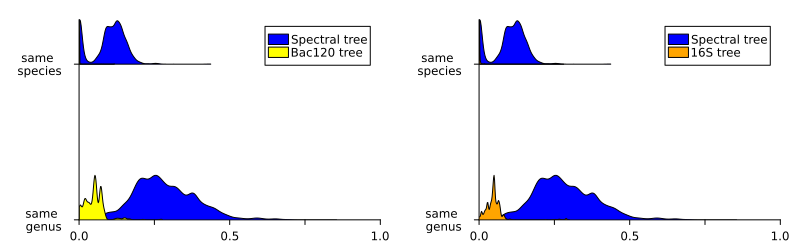

In [395]:
#| code-summary: plot relative density distributions
#| code-fold: true
p1 = plot(
    xlims=(0,1), 
    widen=1, 
    xticks=(0:.25:1, ["0.0", "", "0.5", "", "1.0"]),
    # ylabel="same species",
    # size=(400, 250),
)
# patristic distance of pairs that are the same genus
violin!(["same\n genus"], spiPij_rel[spiTij .== 1], # normed dist
    trim=true, side=:right,
    c=:blue, fill=0, linecolor=:black, lw=1,
    label="Spectral tree",
    permute=(:x, :y),
)
violin!(["same\n genus"], bacPij_rel[bacTij .== 1], # normed dist
    trim=true, side=:right,
    c=:yellow, fill=0, linecolor=:black, lw=1,
    label="Bac120 tree",
    permute=(:x, :y),
)
# patristic distance of pairs that are the same species
violin!(["same\n species"], spiPij_rel[spiTij .== 0], # normed dist
    trim=true, side=:right,
    c=:blue, fill=0, linecolor=:black, lw=1,
    # label="Spectral Tree",
    permute=(:x, :y),
)
violin!(["same\n species"], bacPij_rel[bacTij .== 0], # normed dist
    trim=true, side=:right,
    c=:yellow, fill=0, linecolor=:black, lw=1,
    # label="16S",
    permute=(:x, :y),
)

p2 = plot(
    xlims=(0,1), 
    widen=1, 
    xticks=(0:.25:1, ["0.0", "", "0.5", "", "1.0"]),
    # ylabel="same species",
    # size=(400, 250),
)
# patristic distance of pairs that are the same genus
violin!(["same\n genus"], spiPij_rel[spiTij .== 1], # normed dist
    trim=true, side=:right,
    c=:blue, fill=0, linecolor=:black, lw=1,
    label="Spectral tree",
    permute=(:x, :y),
)
violin!(["same\n genus"], sixPij_rel[sixTij .== 1], # normed dist
    trim=true, side=:right,
    c=:orange, fill=0, linecolor=:black, lw=1,
    label="16S tree",
    permute=(:x, :y),
)
# patristic distance of pairs that are the same species
violin!(["same\n species"], spiPij_rel[spiTij .== 0], # normed dist
    trim=true, side=:right,
    c=:blue, fill=0, linecolor=:black, lw=1,
    # label="Spectral Tree",
    permute=(:x, :y),
)
violin!(["same\n species"], sixPij_rel[sixTij .== 0], # normed dist
    trim=true, side=:right,
    c=:orange, fill=0, linecolor=:black, lw=1,
    # label="16S",
    permute=(:x, :y),
)
plot(p1, p2, layout=grid(1,2), size=(800, 250), margin=3Plots.mm)

In [398]:
# difference in distributions is significant to below floating point precision
# same species distributions
@show pval = pvalue(MannWhitneyUTest(spiPij_rel[spiTij.==0], bacPij_rel[bacTij.==0]); tail=:both);
@show pval = pvalue(MannWhitneyUTest(spiPij_rel[spiTij.==0], sixPij_rel[sixTij.==0]); tail=:both);
# same genus but different species distributions
@show pval = pvalue(MannWhitneyUTest(spiPij_rel[spiTij.==1], bacPij_rel[bacTij.==0]); tail=:both);
@show pval = pvalue(MannWhitneyUTest(spiPij_rel[spiTij.==1], sixPij_rel[sixTij.==0]); tail=:both);

pval = pvalue(MannWhitneyUTest(spiPij_rel[spiTij .== 0], bacPij_rel[bacTij .== 0]); tail = :both) = 0.0
pval = pvalue(MannWhitneyUTest(spiPij_rel[spiTij .== 0], sixPij_rel[sixTij .== 0]); tail = :both) = 0.0
pval = pvalue(MannWhitneyUTest(spiPij_rel[spiTij .== 1], bacPij_rel[bacTij .== 0]); tail = :both) = 0.0
pval = pvalue(MannWhitneyUTest(spiPij_rel[spiTij .== 1], sixPij_rel[sixTij .== 0]); tail = :both) = 0.0


In [397]:
plot(xlims=(0,.3), size=(600,200), tickdir=:out)
histogram!(spiPij_rel[spiTij.==0], nbins=50, c=:blue, alpha=.5, label="Spectral tree")
histogram!(bacPij_rel[bacTij.==0], nbins=15, c=:yellow, alpha=.5, label="Bac120 tree")
histogram!(sixPij_rel[sixTij.==0], nbins=50, c=:orange, alpha=.5, label="16S tree")